In [1]:
"""
Readme: every sessions before "with tf.Session(config=sess_config) as sess:" are for preparing reasons only,
therefore you only need to run these functions ONCE
for further tuning, you can change the parameters starts from "with tf.Session(config=sess_config) as sess"

if you want to predict single photo, change src/config.py DEMO_DYPE = image_path
if you want to predict photos in a folder, change src/config.py DEMO_DYPE = image_path,
  change variable position to the range, for example, [1,3] means predict the 1-th to 3-th images in the dir
if you want to predict a mp4 video, change src/config.py DEMO_DYPE = video_path,
  notice that run video will take much longer time
"""

'\nReadme: every sessions before "with tf.Session(config=sess_config) as sess:" are for preparing reasons only,\ntherefore you only need to run these functions ONCE\nfor further tuning, you can change the parameters starts from "with tf.Session(config=sess_config) as sess"\n\nif you want to predict single photo, change src/config.py DEMO_DYPE = image_path\nif you want to predict photos in a folder, change src/config.py DEMO_DYPE = image_path,\n  change variable position to the range, for example, [1,3] means predict the 1-th to 3-th images in the dir\nif you want to predict a mp4 video, change src/config.py DEMO_DYPE = video_path,\n  notice that run video will take much longer time\n'

In [2]:
import warnings
warnings.simplefilter("ignore")
import tensorflow as tf
import numpy as np
import cv2
import time
import math
import importlib
from PIL import Image
from matplotlib import pyplot as plt
from pathlib import Path

In [3]:
import os
import sys
sys.path.insert(0, 'src')
tensorflow_path = "src/phase1_models"
sys.path.append(tensorflow_path + "/research")
sys.path.append(tensorflow_path + "/research/object_detection")
sys.path.append(tensorflow_path + "/research/object_detection/utils")
sys.path.append(tensorflow_path + "/research/object_detection/utils/slim")
from config import FLAGS
import Detector as dt
import src.video2jpg as v2j
import src.jpg2video as j2v

In [4]:
#None means select all img in a folder, [a, b] means to select a-th to b-th images in the folder
#This variable is for folder prediction only
position = None

In [5]:
#import convolutional pose machine model
cpm_model = importlib.import_module('src.phase2_models.nets.' + FLAGS.network_def)

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(FLAGS.gpu_id)

#build network
model = cpm_model.CPM_Model()
saver = tf.train.Saver()

In [7]:
#GPU settings
output_node = tf.get_default_graph().get_tensor_by_name(name=FLAGS.output_node_names)

device_count = {'GPU': 1} if FLAGS.use_gpu else {'GPU': 0}
sess_config = tf.ConfigProto(device_count=device_count)
sess_config.gpu_options.per_process_gpu_memory_fraction = 0.2
sess_config.gpu_options.allow_growth = True
sess_config.allow_soft_placement = True

In [8]:
def correct_and_draw_hand(full_img, stage_heatmap, crop_img, original_info):
    global_joint = np.zeros((FLAGS.total_joints, 2))
    local_joint = np.zeros((FLAGS.total_joints, 2))

    mean_likelihood = 0.0

    # Plot joint colors
    for joint_num in range(FLAGS.total_joints):
        #this takes the last heatmap
        tmp_heatmap = stage_heatmap[:, :, joint_num]

        #find which position have the largest possibiility to be this joint, and rewrite in form of length-2 list
        joint_coord = np.unravel_index(np.argmax(tmp_heatmap),
                                       (FLAGS.image_size, FLAGS.image_size))
        #for each joint, add its highest(also the taken) score to total response
        mean_likelihood += tmp_heatmap[joint_coord[0], joint_coord[1]]
        joint_coord = np.array(joint_coord).astype(np.float32)

        local_joint[joint_num, :] = joint_coord

        # Resize back
        joint_coord *= original_info[2] / FLAGS.image_size

        joint_coord[0] += original_info[0]
        joint_coord[1] += original_info[1]
        global_joint[joint_num, :] = joint_coord

    #if mean_likelihood >= 5:
    #if we feel like it fails, then we will don't place hand on the screen
    draw_hand(full_img, global_joint)
    draw_hand(crop_img, local_joint)


    #we put response on crop image, and original image
    cv2.putText(crop_img, 'Likelihood: {:<.3f}'.format(mean_likelihood / FLAGS.total_joints),
                org=(20, 20), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=1, color=(255, 0, 0))
    cv2.putText(full_img, 'Likelihood: {:<.3f}'.format(mean_likelihood / FLAGS.total_joints),
            org=(original_info[1], original_info[0]), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=1, color=(255, 0, 0))


In [9]:
#draw hand points and circles on the canvas
def draw_hand(canvas, joint): 
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in range(len(joint)):
        cv2.circle(canvas, (int(joint[i][1]),int(joint[i][0])), 4, FLAGS.joint_color_code[i], thickness=-1)
    for edge in FLAGS.limbs:
        u,v = edge
        cv2.line(canvas,(int(joint[u][1]),int(joint[u][0])),(int(joint[v][1]),int(joint[v][0])),FLAGS.joint_color_code[v],3)

def normalize_and_centralize_img(img):
    #input from -0.5~+0.5
    norm_img = img / 256.0 - 0.5
    return np.expand_dims(norm_img, axis=0)

In [10]:
def predict_image(padding, position=None):
    print("Prediction starts...")
    test_img = [] #store all the images in this directory, no matter a folder of photos or a single photo
    img_name = [] #list for image names
    if FLAGS.DEMO_TYPE.endswith(('png', 'jpg')):
        test_img.append(cv2.imread(FLAGS.DEMO_TYPE))
        img_name.append(FLAGS.DEMO_TYPE)
    elif FLAGS.DEMO_TYPE.endswith('mp4'):
        for file in os.listdir('src/video_dir/sequence_img'):
            os.remove('src/video_dir/sequence_img/' + file)
        for file in os.listdir('src/video_dir/labeled_img'):
            os.remove('src/video_dir/labeled_img/' + file)  
        if Path('src/video_dir/output.mp4').is_file():
            os.remove('src/video_dir/output.mp4')
        print("Old intermediate file removed, if any")
        v2j.extractImages(FLAGS.DEMO_TYPE, 'src/video_dir/sequence_img', 'src/video_dir/labeled_img')
        file_list = sorted(os.listdir('src/video_dir/sequence_img'))
        for img in file_list:
            test_img.append(cv2.imread(os.path.join('src/video_dir/sequence_img', img)))
            img_name.append(os.path.join('src/video_dir/sequence_img', img))
    else:
        file_list = sorted(os.listdir(FLAGS.DEMO_TYPE))
        if position!= None:
            file_list = file_list[position[0]:position[1]]

        for img in file_list:
            if not img.endswith(('png', 'jpg')):
                #avoid error from ./checkpoint
                continue
            test_img.append(cv2.imread(os.path.join(FLAGS.DEMO_TYPE, img)))
            img_name.append(os.path.join(FLAGS.DEMO_TYPE, img))
    tt = time.time()
    if FLAGS.DEMO_TYPE.endswith('mp4'):
        boxes = dt.bounding_box_from_folder('src/video_dir/sequence_img', padding, position)
    else:
        boxes = dt.bounding_box_from_folder(FLAGS.DEMO_TYPE, padding, position)
    print("Time for Phase 1 Hand Detection: ", time.time() - tt)

    tmp_img_list = []
    for index, b_box in enumerate(boxes):
        t0 = time.time()
        bb_img = []
        bb_img_resize = []
        original_info = [] #so that can be recovered from original size and position, with order: ymin, xmin, original length/width
        if b_box != []: 
            bb_box = b_box[0]
            bb_img.append(np.copy(test_img[index][bb_box[1]:bb_box[3],bb_box[0]:bb_box[2],:]))
            original_info.append([bb_box[1], bb_box[0], bb_img[0].shape[0]])
            if len(b_box) > 1: 
                bb_box = b_box[1]
                bb_img.append(np.copy(test_img[index][bb_box[1]:bb_box[3],bb_box[0]:bb_box[2],:])) 
                original_info.append([bb_box[1], bb_box[0], bb_img[1].shape[0]])

        # this is useless, because it already forces to input size
        for i in range(len(bb_img)):
            bb_img[i] = cv2.resize(bb_img[i], (FLAGS.image_size, FLAGS.image_size))
            bb_img_resize.append(normalize_and_centralize_img(bb_img[i]))

            #t1 = time.time()

            stage_heatmap_np = sess.run(output_node,
                                        feed_dict={model.input_images:bb_img_resize[i]})
            #frame per second
            #print('fps: %.2f' % (1 / (time.time() - t1)))

            correct_and_draw_hand(test_img[index],
                                  cv2.resize(stage_heatmap_np[0], (FLAGS.image_size, FLAGS.image_size)),
                                  bb_img[i], original_info[i])

        # Show visualized image
        tmp_img = cv2.resize(test_img[index], (1280, 720))      
        #cv2.imshow(img_name[index] + '-0', tmp_img.astype(np.uint8))
        tmp_img_list.append(tmp_img)
        print("Gesture estimation time for " + str(index) + ": " +str(time.time() - t0))
    return tmp_img_list

In [11]:
with tf.Session(config=sess_config) as sess:

    model_path_suffix = 'stages_{}'.format(FLAGS.total_stages)
    # the folder to save and reload weight
    model_save_dir = os.path.join('src/phase2_models',
                                  'weights',
                                  model_path_suffix)
    print('Load model from [{}]'.format(os.path.join(model_save_dir, FLAGS.pretrained_model)))

    if FLAGS.pretrained_model != '':
        saver.restore(sess, os.path.join(model_save_dir, FLAGS.pretrained_model))
              
    t1 = time.time()
    #we assume they are all images, either folder or single image file
    #if FLAGS.DEMO_TYPE.endswith(('png', 'jpg')): 
    predictions = predict_image(FLAGS.padding, None) # the second argument works as range [x, y] indicates from x-th to y-th for a folder
    print("The total time we use is: ", time.time() - t1)
    #cv2.waitKey(0)

Load model from [src/phase2_models/weights/stages_3/cpm_model-200000]
INFO:tensorflow:Restoring parameters from src/phase2_models/weights/stages_3/cpm_model-200000
Prediction starts...
Old intermediate file removed, if any
Extraction starts
149  images have been generated
Time for Phase 1 Hand Detection:  281.18538904190063
Gesture estimation time for 0: 2.139137029647827
Gesture estimation time for 1: 2.067485809326172
Gesture estimation time for 2: 2.055717945098877
Gesture estimation time for 3: 2.1070659160614014
Gesture estimation time for 4: 2.051129102706909
Gesture estimation time for 5: 2.090785026550293
Gesture estimation time for 6: 2.279539108276367
Gesture estimation time for 7: 2.0984578132629395
Gesture estimation time for 8: 2.1012086868286133
Gesture estimation time for 9: 2.081990957260132
Gesture estimation time for 10: 2.180450916290283
Gesture estimation time for 11: 2.2953178882598877
Gesture estimation time for 12: 2.141462802886963
Gesture estimation time for 13

In [12]:
#write images to folder
if FLAGS.DEMO_TYPE.endswith('mp4'):
    for idx, img in enumerate(predictions):
        cv2.imwrite("src/video_dir/labeled_img/" + "/%08d.jpg" % idx, img)
    j2v.jpg_to_video('src/video_dir/labeled_img', 'src/video_dir/output.mp4')
else:
    for idx, img in enumerate(predictions): 
        cv2.imwrite("src/predict_img/" + str(idx) + ".jpg", img)

The output video is src/video_dir/output.mp4


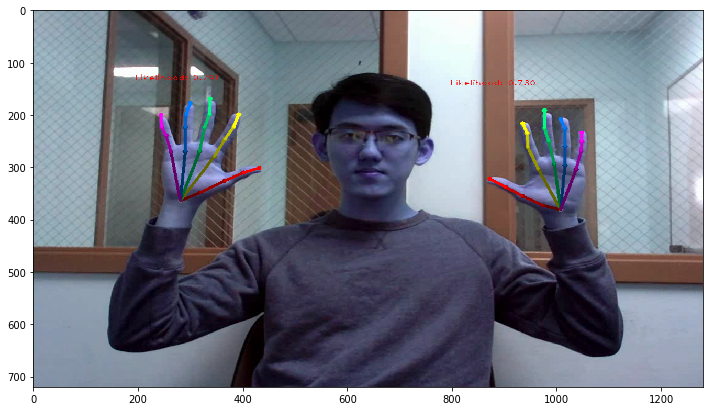

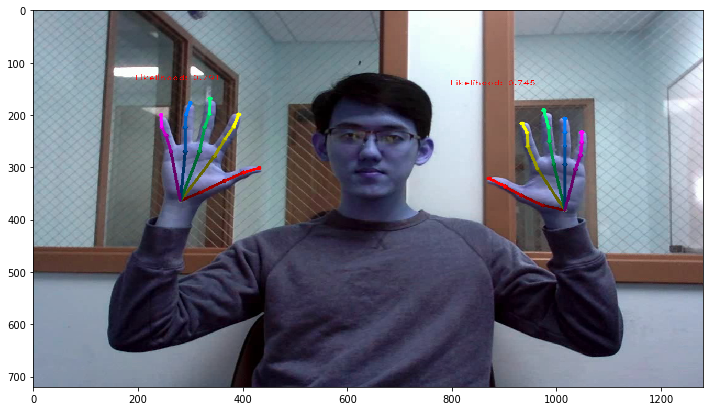

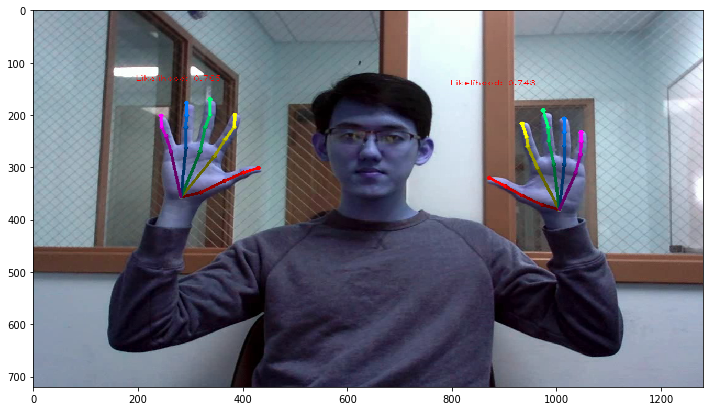

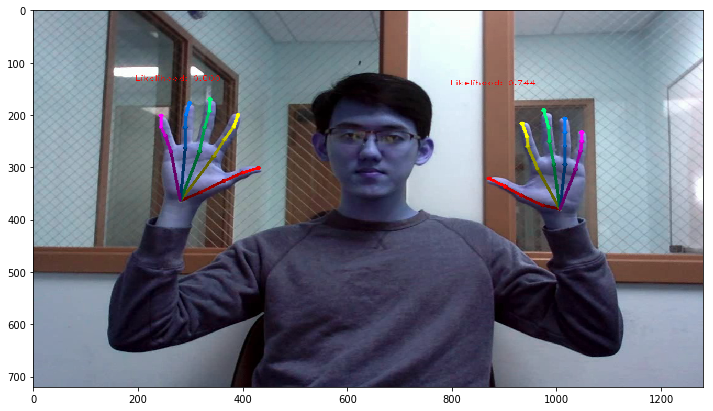

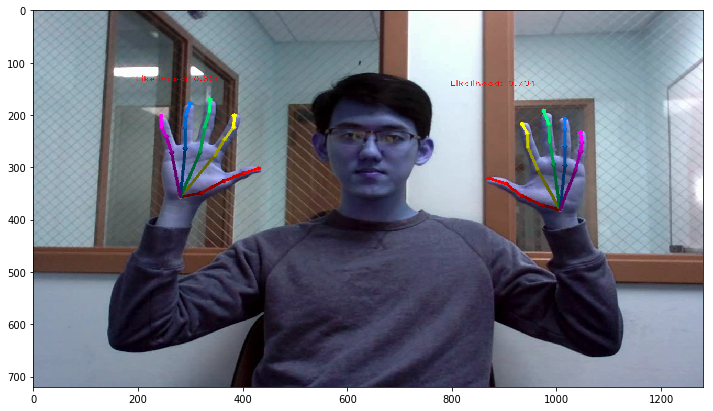

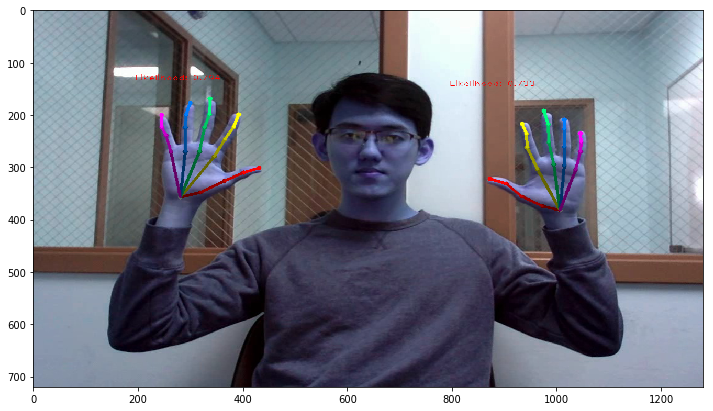

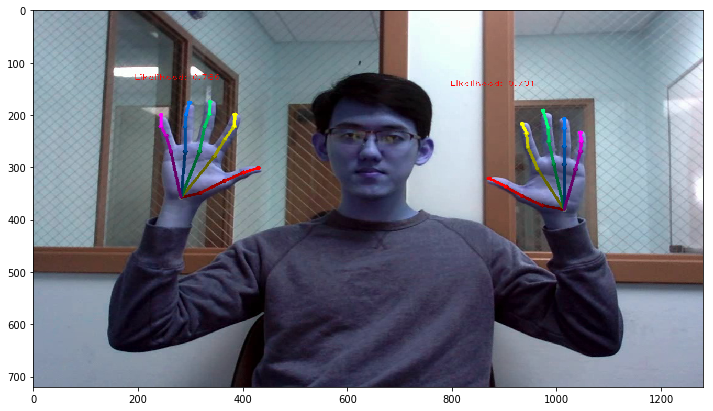

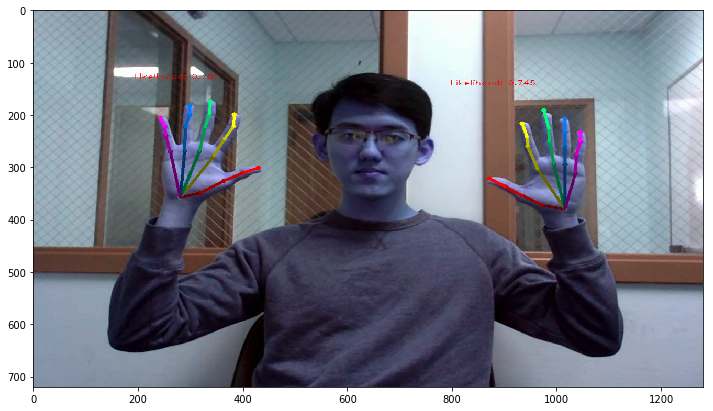

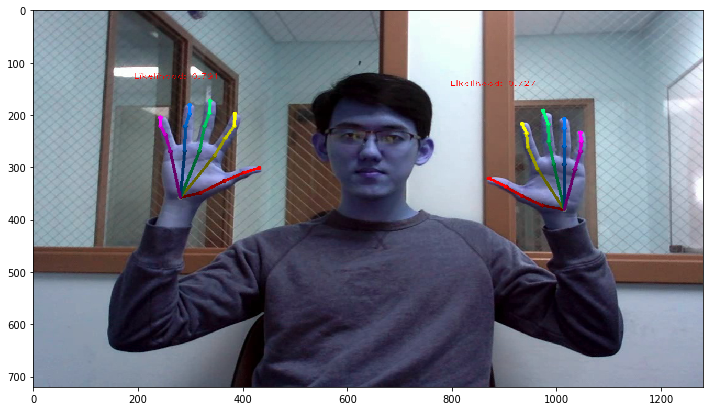

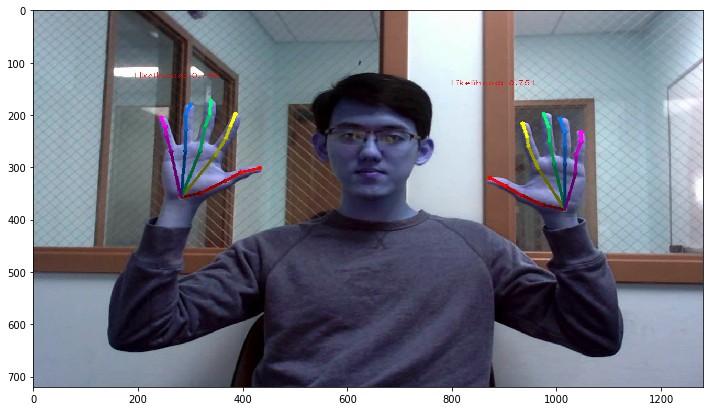

In [13]:
# need to manually change the index, because cv2 on GCP cannot ue imshow, thus only use Image in matplotlib
for idx, img in enumerate(predictions):
    if FLAGS.DEMO_TYPE.endswith('mp4') and idx == 10:
        # there could be hundreds of images for a video, we don't want it all to be seen
        break
    plt.figure(figsize=(12,8))
    plt.imshow(img)